In [28]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#import wrangle
import env
import seaborn as sns
import acquire
import prep
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split


import prep
import seaborn as sns
from sklearn.cluster import KMeans


import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from math import sqrt
import warnings
from statsmodels.formula.api import ols

In [2]:
#single family residence from zillow DB
df = prep.prep_df()

In [3]:
df.head().T

,0,1,2,3,4
bathrooms,2.000000e+00,4.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00
bedrooms,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00
sqft,3.633000e+03,1.620000e+03,2.077000e+03,1.244000e+03,1.300000e+03
tax_value,2.964250e+05,8.477700e+05,6.467600e+05,1.694710e+05,2.332660e+05
fips,6.037000e+03,6.037000e+03,6.037000e+03,6.037000e+03,6.037000e+03
latitude,3.456002e+07,3.399620e+07,3.401298e+07,3.395356e+07,3.389713e+07
longitude,-1.181698e+08,-1.184380e+08,-1.184792e+08,-1.180839e+08,-1.181030e+08
lotsizesquarefeet,9.826000e+03,1.284275e+04,6.490000e+03,6.021000e+03,4.917000e+03
regionidcity,4.022700e+04,1.244700e+04,2.696400e+04,1.371600e+04,5.363600e+04
regionidcounty,3.101000e+03,3.101000e+03,3.101000e+03,3.101000e+03,3.101000e+03


In [54]:
train, test = train_test_split(df, train_size = .75, random_state = 123)
train['tax_per_sqft'] = train.tax_value/train.sqft

In [55]:
X_train = train.drop(columns=['logerror','fips','latitude','longitude','regionidcity','regionidcounty','regionidzip'])
y_train = train[['logerror']]
X_test = test.drop(columns=['logerror','fips','latitude','longitude','regionidcity','regionidcounty','regionidzip'])
y_test = test[['logerror']]
X_train.tax_value = X_train.tax_value /1000
X_train.structuretaxvaluedollarcnt = X_train.structuretaxvaluedollarcnt/1000


In [56]:
#adding a baseline yhat as mean of log error
train['mean_logerror'] = train.logerror.mean()
train['residual'] = train['logerror']- train['mean_logerror']

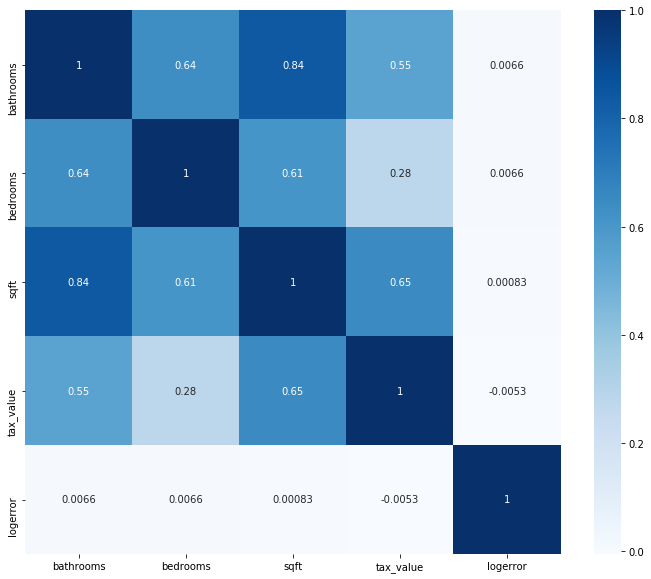

In [57]:
plt.figure(figsize=(12,10))
subset = train[['bathrooms','bedrooms','sqft','tax_value','logerror']]
cor = subset.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Blues)
plt.show()

In [58]:
# MSE of baseline
train['residual^2'] = train.residual ** 2
SSE = sum(train['residual^2'])
MSE = SSE/len(train)
print("MSE = ", MSE)

MSE =  0.028226598428296255


In [59]:
x = train[['sqft','bedrooms']]
y = train[['logerror']]
ols_model = ols('y ~ x', data=train).fit()
train['yhat'] = ols_model.predict(x)
r2 = ols_model.rsquared
print('r squared = ',round(r2,7))

r squared =  5.88e-05


In [60]:
#MSE of sqft and bedrooms as x variables
train['residual^2'] = train.residual ** 2
SSE = sum(train['residual^2'])
MSE = SSE/len(train)
print("MSE = ", MSE)

MSE =  0.028226598428296255


In [61]:
#Model1 performs very slightly better than the baseline
baseline = mean_squared_error(train.logerror,train.mean_logerror)
model1 = mean_squared_error(train.logerror,train.yhat)
print("Baseline: ",baseline)
print("Model1: ",model1)
baseline<model1

Baseline:  0.028226598428296407
Model1:  0.028224938702324065


False

In [62]:
def target_cluster(y_train,X_train):
    kmeans =KMeans(n_clusters=5)
    kmeans.fit(y_train)
    y_train['cluster'] = kmeans.predict(y_train)
    train = X_train.merge(y_train,left_index=True,right_index=True)
    return train

True